In [1]:
import os
import random
import pandas as pd
import numpy as np
import gc


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = '{:.5f}'.format

import warnings
warnings.filterwarnings('ignore')


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(33) # Seed 고정

In [3]:
light_df = pd.read_csv('C:/Users/user/Desktop/데이콘/교통사고/open/open/external_open/대구보안등정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
light_df = light_df.rename(columns={'설치개수': '보안등 설치개수'})

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('C:/Users/user/Desktop/데이콘/교통사고/open/open/external_open/대구어린이보호구역정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소', 'CCTV설치대수']]
# 어린이 보호구역을 의미
child_area_df['보호구역'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('C:/Users/user/Desktop/데이콘/교통사고/open/open/external_open/대구주차장정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

cctv_df = pd.read_csv('C:/Users/user/Desktop/데이콘/교통사고/open/open/external_open/대구CCTV정보.csv', encoding='cp949')[['소재지지번주소', '단속구분']]
cctv_df = pd.get_dummies(cctv_df, columns=['단속구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동', '번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소', '번지'])

cctv_df = cctv_df.groupby(['도시', '구', '동']).sum().reset_index()
cctv_df.reset_index(inplace=True, drop=True)

In [4]:
train_org = pd.read_csv('C:/Users/user/Desktop/데이콘/교통사고/open/open/train.csv')
test_org = pd.read_csv('C:/Users/user/Desktop/데이콘/교통사고/open/open/test.csv')
sample_submission = pd.read_csv('C:/Users/user/Desktop/데이콘/교통사고/open/open/sample_submission.csv')


In [5]:
train_df = train_org.copy()
test_df = test_org.copy()

In [6]:
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

In [7]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옴
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
# '시군구'별 사고 횟수를 test_df 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옴
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
test_df = test_df.drop(columns=['시군구'])

In [8]:
display(train_df)
display(test_df)

,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,도시,구,동,사고발생횟수
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,중상,0,1,0,0,5,대구광역시,중구,대신동,131
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,...,경상,0,0,1,0,3,대구광역시,달서구,감삼동,678
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,경상,0,0,1,0,3,대구광역시,수성구,두산동,604
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,중상,0,1,0,0,5,대구광역시,북구,복현동,426
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,경상,0,0,1,0,3,대구광역시,동구,신암동,825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,...,경상,0,0,1,0,3,대구광역시,수성구,수성동3가,104
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,...,경상,0,0,1,0,3,대구광역시,달서구,상인동,1143
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,...,중상,0,2,0,0,10,대구광역시,달서구,월성동,618
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,경상,0,0,1,0,3,대구광역시,달서구,장동,125


,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,도시,구,동,사고발생횟수
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,교차로 - 교차로안,건조,차대사람,대구광역시,수성구,상동,338
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,단일로 - 기타,건조,차대사람,대구광역시,수성구,지산동,492
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,교차로 - 교차로안,건조,차대차,대구광역시,수성구,수성동2가,147
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,단일로 - 기타,건조,차대차,대구광역시,수성구,신매동,372
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,교차로 - 교차로안,건조,차대차,대구광역시,달서구,감삼동,678
...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,단일로 - 터널,건조,차대차,대구광역시,남구,대명동,1749
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,단일로 - 기타,건조,차대차,대구광역시,수성구,시지동,167
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,단일로 - 기타,건조,차대차,대구광역시,수성구,연호동,107
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,교차로 - 교차로부근,건조,차대차,대구광역시,수성구,범물동,239


In [9]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [10]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, cctv_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, cctv_df, how='left', on=['도시', '구', '동'])

In [11]:
test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

In [12]:
train_x.isna().sum()

사고일시            0
요일              0
기상상태            0
노면상태            0
사고유형            0
도시              0
구               0
동               0
사고발생횟수          0
도로형태1           0
도로형태2           0
보안등 설치개수     9513
CCTV설치대수    18426
보호구역        18426
급지구분_1       6543
급지구분_2       6543
급지구분_3       6543
단속구분_1       1576
단속구분_2       1576
단속구분_4       1576
단속구분_99      1576
dtype: int64

In [13]:
test_x.isna().sum()

사고일시           0
요일             0
기상상태           0
노면상태           0
사고유형           0
도시             0
구              0
동              0
사고발생횟수         0
도로형태1          0
도로형태2          0
보안등 설치개수    2771
CCTV설치대수    4961
보호구역        4961
급지구분_1      1928
급지구분_2      1928
급지구분_3      1928
단속구분_1       455
단속구분_2       455
단속구분_4       455
단속구분_99      455
dtype: int64

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IterativeImputer 모델 생성
imputer = IterativeImputer(max_iter=10, random_state=0)

# '보안등 설치개수','CCTV설치대수','보호구역', '급지구분_1', '급지구분_2', '급지구분_3','단속구분_1','단속구분_2','단속구분_4','단속구분_99' 열을 포함한 열들 선택
selected_columns = ['보안등 설치개수', 'CCTV설치대수', '보호구역', '급지구분_1', '급지구분_2', '급지구분_3',
                    '단속구분_1','단속구분_2','단속구분_4','단속구분_99']
data_for_imputation = train_x[selected_columns]

# IterativeImputer를 사용하여 결측치 채우기
imputed_data = imputer.fit_transform(data_for_imputation)

# 결과를 기존 데이터프레임에 적용
train_x[selected_columns] = imputed_data

# train 데이터프레임에 결측치가 없는지 확인
train_x.isna().sum()


사고일시        0
요일          0
기상상태        0
노면상태        0
사고유형        0
도시          0
구           0
동           0
사고발생횟수      0
도로형태1       0
도로형태2       0
보안등 설치개수    0
CCTV설치대수    0
보호구역        0
급지구분_1      0
급지구분_2      0
급지구분_3      0
단속구분_1      0
단속구분_2      0
단속구분_4      0
단속구분_99     0
dtype: int64

In [15]:
# '보안등 설치개수','CCTV설치대수','보호구역', '급지구분_1', '급지구분_2', '급지구분_3','단속구분_1','단속구분_2','단속구분_4','단속구분_99' 열을 포함한 열들 선택
selected_columns = ['보안등 설치개수', 'CCTV설치대수', '보호구역', '급지구분_1', '급지구분_2', '급지구분_3',
                    '단속구분_1','단속구분_2','단속구분_4','단속구분_99']
data_for_imputation = test_x[selected_columns]

# IterativeImputer를 사용하여 결측치 채우기
imputed_data = imputer.transform(data_for_imputation)

# 결과를 기존 데이터프레임에 적용
test_x[selected_columns] = imputed_data

# test 데이터프레임에 결측치가 없는지 확인
test_x.isna().sum()

사고일시        0
요일          0
기상상태        0
노면상태        0
사고유형        0
도시          0
구           0
동           0
사고발생횟수      0
도로형태1       0
도로형태2       0
보안등 설치개수    0
CCTV설치대수    0
보호구역        0
급지구분_1      0
급지구분_2      0
급지구분_3      0
단속구분_1      0
단속구분_2      0
단속구분_4      0
단속구분_99     0
dtype: int64

In [16]:
# '사고일시' 열을 datetime 형식으로 변환
train_x['사고일시'] = pd.to_datetime(train_x['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
train_x['year'] = train_x['사고일시'].dt.year
train_x['month'] = train_x['사고일시'].dt.month
train_x['day'] = train_x['사고일시'].dt.day
train_x['hour'] = train_x['사고일시'].dt.hour
train_x['day_of_week'] = train_x['사고일시'].dt.dayofweek

In [17]:
# '사고일시' 열을 datetime 형식으로 변환
test_x['사고일시'] = pd.to_datetime(test_x['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
test_x['year'] = test_x['사고일시'].dt.year
test_x['month'] = test_x['사고일시'].dt.month
test_x['day'] = test_x['사고일시'].dt.day
test_x['hour'] = test_x['사고일시'].dt.hour
test_x['day_of_week'] = test_x['사고일시'].dt.dayofweek

In [18]:
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']
# 공휴일 변수생성
train_x['holiday'] = np.where((train_x.day_of_week >= 5) | (train_x.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)
test_x['holiday'] = np.where((test_x.day_of_week >= 5) | (test_x.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [19]:
# '사고일시' 열 삭제
train_x.drop(columns=['사고일시'], inplace=True)
# '사고일시' 열 삭제
test_x.drop(columns=['사고일시'], inplace=True)

In [20]:
# 계절 변수 생성
def group_season(df):
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'season'] = '봄'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'season'] = '여름'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'season'] = '가을'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'season'] = '겨울'
    return df['season']

train_x['season'] = group_season(train_x)
test_x['season'] = group_season(test_x)

In [21]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2', 'season']

,요일,기상상태,노면상태,사고유형,도시,구,동,사고발생횟수,도로형태1,도로형태2,...,단속구분_2,단속구분_4,단속구분_99,year,month,day,hour,day_of_week,holiday,season
0,4.62793,4.71289,4.71288,3.81765,4.72670,4.54161,4.28245,131,4.67184,4.59960,...,1.00000,4.00000,0.00000,2019,1,1,0,1,1,4.65911
1,4.62793,4.77915,4.71288,3.81765,4.72670,4.61844,4.73894,678,4.67184,4.59960,...,3.00000,8.00000,0.00000,2019,1,1,0,1,1,4.65911
2,4.62793,4.71289,4.71288,3.81765,4.72670,4.72730,4.84272,604,4.67184,4.59960,...,2.00000,0.00000,0.00000,2019,1,1,1,1,1,4.65911
3,4.62793,4.71289,4.71288,4.94460,4.72670,4.68767,4.20892,426,4.67184,4.59960,...,8.00000,0.00000,0.00000,2019,1,1,2,1,1,4.65911
4,4.62793,4.71289,4.71288,4.94460,4.72670,4.88953,4.54909,825,4.67184,4.59960,...,10.00000,0.00000,0.00000,2019,1,1,4,1,1,4.65911


,요일,기상상태,노면상태,사고유형,도시,구,동,사고발생횟수,도로형태1,도로형태2,...,단속구분_2,단속구분_4,단속구분_99,year,month,day,hour,day_of_week,holiday,season
0,4.92081,4.71289,4.71288,3.81765,4.72670,4.72730,4.88166,338,4.88228,5.00614,...,4.00000,0.00000,0.00000,2022,1,1,1,5,1,4.65911
1,4.92081,4.71289,4.71288,3.81765,4.72670,4.72730,4.56301,492,4.67184,4.59960,...,7.00000,0.00000,0.00000,2022,1,1,1,5,1,4.65911
2,4.92081,4.71289,4.71288,4.94460,4.72670,4.72730,4.94558,147,4.88228,5.00614,...,1.00000,0.00000,0.00000,2022,1,1,4,5,1,4.65911
3,4.92081,4.71289,4.71288,4.94460,4.72670,4.72730,4.43817,372,4.67184,4.59960,...,9.00000,0.00000,0.00000,2022,1,1,4,5,1,4.65911
4,4.92081,4.71289,4.71288,4.94460,4.72670,4.61844,4.73894,678,4.88228,5.00614,...,3.00000,8.00000,0.00000,2022,1,1,6,5,1,4.65911


In [22]:
import matplotlib
matplotlib.use('Agg')

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_x)
test_scaled = scaler.transform(test_x)

X_train = pd.DataFrame(train_scaled, columns = train_x.columns)
test = pd.DataFrame(test_scaled, columns = test_x.columns)

In [24]:
from supervised.automl import AutoML

automl = AutoML(algorithms = ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
                eval_metric='rmse', ml_task='regression', mode='Compete',n_jobs=-1,
                 total_time_limit=None, model_time_limit=None)


In [25]:
automl.fit(X_train, train_y)

AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 4 models
1_Default_LightGBM rmse 3.233965 trained in 5.85 seconds
2_Default_Xgboost rmse 3.234303 trained in 7.05 seconds
3_Default_CatBoost rmse 3.228677 trained in 10.27 seconds
4_Default_RandomForest rmse 3.239187 trained in 27.68 seconds
* Step not_so_random will try to check up to 36 models
14_LightGBM rmse 3.231969 trained in 6.02 seconds
5_Xgboost rmse 3.238352 trained in 9.81 seconds
23_CatBoost rm

45_Xgboost_Stacked rmse 3.232115 trained in 15.37 seconds
52_LightGBM_Stacked rmse 3.230166 trained in 12.5 seconds
36_RandomForest_Stacked rmse 3.226644 trained in 368.59 seconds
31_CatBoost_GoldenFeatures_Stacked rmse 3.22854 trained in 50.12 seconds
66_Xgboost_Stacked rmse 3.2309 trained in 15.86 seconds
67_LightGBM_SelectedFeatures_Stacked rmse 3.229761 trained in 12.77 seconds
73_RandomForest_Stacked rmse 3.225457 trained in 339.81 seconds
55_CatBoost_Stacked rmse 3.227415 trained in 18.85 seconds
65_Xgboost_Stacked rmse 3.231738 trained in 14.83 seconds
49_LightGBM_Stacked rmse 3.229998 trained in 13.18 seconds
35_RandomForest_Stacked rmse 3.225893 trained in 192.74 seconds
58_CatBoost_GoldenFeatures_Stacked rmse 3.228703 trained in 27.41 seconds
47_Xgboost_SelectedFeatures_Stacked rmse 3.229654 trained in 14.87 seconds
22_LightGBM_Stacked rmse 3.230113 trained in 13.23 seconds
34_RandomForest_Stacked rmse 3.225772 trained in 396.75 seconds
64_Xgboost_Stacked rmse 3.229891 traine

AutoML(algorithms=['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
       eval_metric='rmse', ml_task='regression', mode='Compete',
       total_time_limit=None)

In [26]:
pred = automl.predict(test)
sample_submission['ECLO'] = pred
sample_submission.loc[ sample_submission['ECLO'] < 0.0, 'ECLO'] = 0.0

In [31]:
sample_submission.to_csv('C:/Users/user/Desktop/데이콘/교통사고/result/automl.csv',index=False)

In [28]:
sample_submission

,ID,ECLO
0,ACCIDENT_39609,3.88111
1,ACCIDENT_39610,3.40710
2,ACCIDENT_39611,5.01506
3,ACCIDENT_39612,4.31921
4,ACCIDENT_39613,4.53937
...,...,...
10958,ACCIDENT_50567,5.11213
10959,ACCIDENT_50568,4.35708
10960,ACCIDENT_50569,4.60579
10961,ACCIDENT_50570,4.47505


In [53]:
pytorch_submisiion=pd.read_csv("C:/Users/user/Desktop/데이콘/교통사고/result/submission_토치11.csv")

In [3]:
submission_ensemble = pd.read_csv('C:/Users/user/Desktop/데이콘/교통사고/open/open/sample_submission.csv')

In [56]:
submission_ensemble['ECLO'] = (sample_submission['ECLO'] + pytorch_submisiion['ECLO'])/2

In [4]:
pytorch_submisiion=pd.read_csv("C:/Users/user/Desktop/데이콘/교통사고/result/submission_토치_best.csv")

In [5]:
pytorch_submisiion_random=pd.read_csv("C:/Users/user/Desktop/데이콘/교통사고/result/submission_토치_랜덤.csv")

In [6]:
automl=pd.read_csv("C:/Users/user/Desktop/데이콘/교통사고/result/automl.csv")

In [10]:
submission_ensemble['ECLO'] = (automl['ECLO'] + pytorch_submisiion['ECLO'])/2

In [11]:
submission_ensemble

,ID,ECLO
0,ACCIDENT_39609,3.86457
1,ACCIDENT_39610,3.45617
2,ACCIDENT_39611,4.90064
3,ACCIDENT_39612,4.24180
4,ACCIDENT_39613,4.48032
...,...,...
10958,ACCIDENT_50567,5.26531
10959,ACCIDENT_50568,4.32759
10960,ACCIDENT_50569,4.66515
10961,ACCIDENT_50570,4.58611


In [12]:
submission_ensemble.to_csv('C:/Users/user/Desktop/데이콘/교통사고/result/ensemble7.csv',index=False)

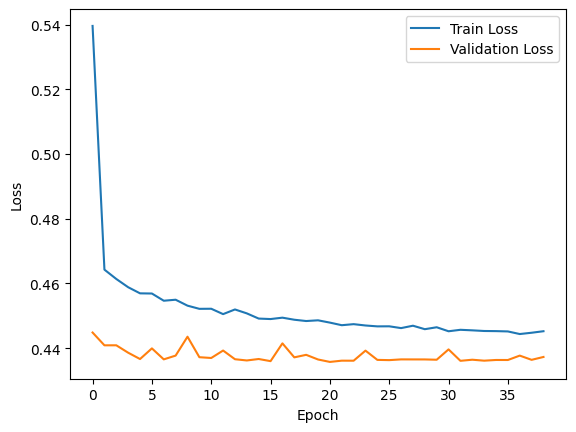

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 테스트 데이터로 예측
with torch.no_grad():
    model.eval()
    test_inputs = torch.tensor(test_x.values, dtype=torch.float32)
    # test_inputs를 모델이 사용하는 디바이스로 옮기기
    test_inputs = test_inputs.to(device)
    predictions = model(test_inputs)

# 예측 결과 출력
print(predictions)

tensor([[3.9154],
        [3.4348],
        [4.9877],
        ...,
        [4.6195],
        [4.6422],
        [4.4544]], device='cuda:0')
